# 空气质量时间序列预测

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. 数据加载

In [186]:
data_df = pd.read_csv('./air_quality.csv', index_col='date', parse_dates=True)
data_df.head(10)

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9


In [187]:
# 存在缺失值
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Data columns (total 1 columns):
co2    2225 non-null float64
dtypes: float64(1)
memory usage: 35.7 KB


In [188]:
# 缺失值处理
data_df.bfill(inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Data columns (total 1 columns):
co2    2284 non-null float64
dtypes: float64(1)
memory usage: 35.7 KB


In [189]:
data_df.head(10)

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,317.5
1958-05-17,317.5
1958-05-24,317.9


In [190]:
# 数据重采样
proc_data_df = data_df['co2'].resample('MS').mean().to_frame()
proc_data_df.head(10)

,co2
date,
1958-03-01,316.100
1958-04-01,317.200
1958-05-01,317.120
1958-06-01,315.800
1958-07-01,315.625
1958-08-01,314.780
1958-09-01,313.125
1958-10-01,313.000
1958-11-01,313.340


In [191]:
train_ts = proc_data_df.loc[:'1999'][['co2']]
test_ts = proc_data_df.loc['2000':][['co2']]

In [192]:
train_ts.tail()

,co2
date,
1999-08-01,366.700
1999-09-01,364.675
1999-10-01,365.140
1999-11-01,366.650
1999-12-01,367.900


In [193]:
test_ts.head()

,co2
date,
2000-01-01,369.020
2000-02-01,369.375
2000-03-01,370.400
2000-04-01,371.540
2000-05-01,371.650


## 2. 平稳性检验及处理

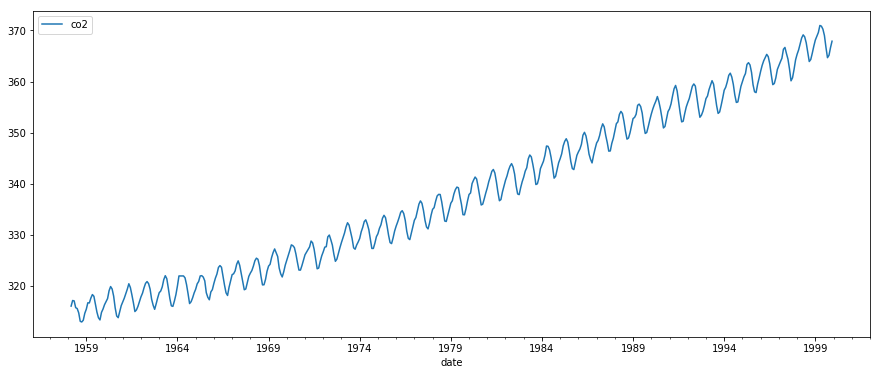

In [194]:
train_ts.plot(figsize=(15, 6))
plt.show()

In [195]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts, thresh=0.05):
    """
        检验ts时序是否稳定
    """
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1] <= thresh

In [196]:
check_stationarity(train_ts['co2'])

ADF Statistic: 2.528225
p-value: 0.999058
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


False

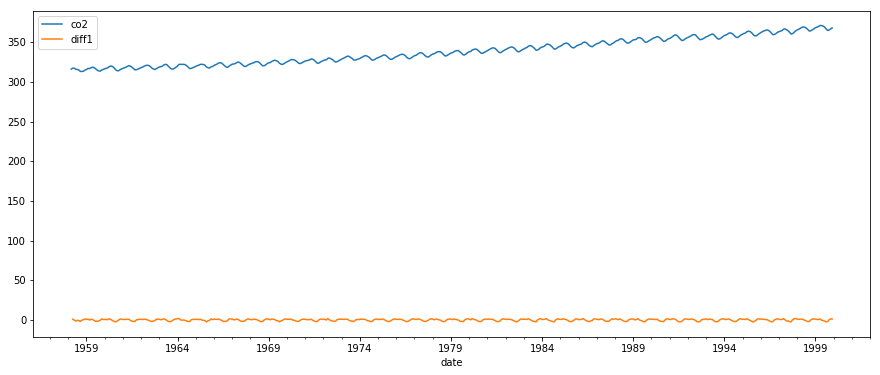

In [197]:
train_ts['diff1'] = train_ts['co2'].diff(1)
train_ts.plot(figsize=(15, 6))

In [198]:
check_stationarity(train_ts['diff1'].dropna())

ADF Statistic: -4.939458
p-value: 0.000029
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


True

## 3. ARIMA模型定阶

通过平稳性分析，可得d=1

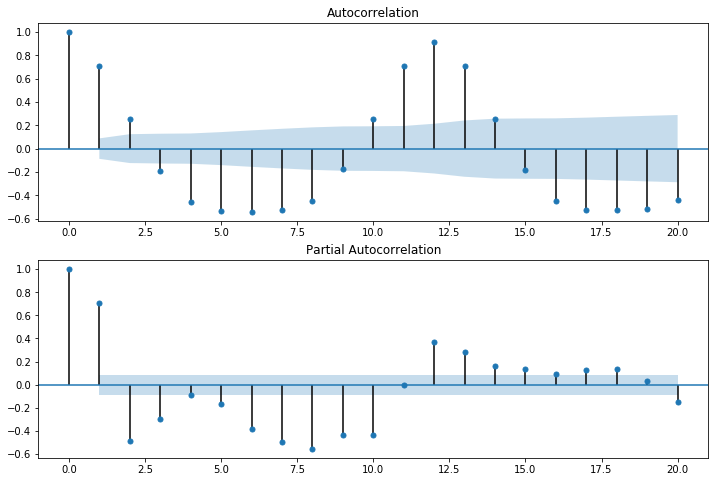

In [199]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_ts['diff1'].dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_ts['diff1'].dropna(), lags=20, ax=ax2)

依靠经验选择p=2, q=2

In [200]:
from statsmodels.tsa.arima_model import ARIMA

In [201]:
ts = train_ts['co2']
model = ARIMA(ts, order=(2, 1, 2))
results = model.fit()

In [202]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.co2   No. Observations:                  501
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -463.490
Method:                       css-mle   S.D. of innovations              0.608
Date:                Fri, 05 Oct 2018   AIC                            938.980
Time:                        23:09:33   BIC                            964.280
Sample:                    04-01-1958   HQIC                           948.907
                         - 12-01-1999                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1078      0.007     15.068      0.000       0.094       0.122
ar.L1.D.co2     1.5759      0.028     56.296      0.000       1.521       1.631
ar.L2.D.co2    -0.8726      0.027    -32.751      0.000      -0.925      -0.820
ma.L1.D.co2    -1.0002      0.069    -14.407      0.000      -1.136      -0.864
ma.L2.D.co2     0.0765      0.067      1.138      0.256      -0.055       0.208
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9030           -0.5750j            1.0705           -0.0902
AR.2            0.9030           +0.5750j            1.0705            0.0902
MA.1            1.0908           +0.0000j            1.0908            0.0000
MA.2           11.9797           +0.0000j           11.9797            0.0000
-----------------------------------------------------------------------------
"""

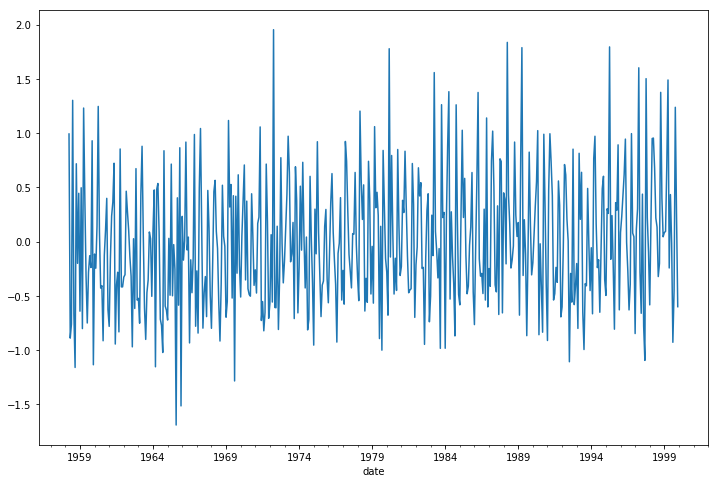

In [203]:
results.resid.plot(figsize=(12, 8))

In [204]:
results.resid.describe()

count    501.000000
mean      -0.002059
std        0.612202
min       -1.690054
25%       -0.470681
50%       -0.063159
75%        0.405480
max        1.953282
dtype: float64

网格搜索定阶

In [205]:
import itertools

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

In [206]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [207]:
param_list = []
aic_list = []
results_df = pd.DataFrame()

for param in pdq:
    try:
        model = ARIMA(ts, order=param)
        results = model.fit()

        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        param_list.append(param)
        aic_list.append(results.aic)
    except:
        continue
        
results_df['pdq'] = param_list
results_df['aic'] = aic_list
results_df

ARIMA(0, 0, 0) - AIC:4219.32275751172
ARIMA(0, 0, 1) - AIC:3542.984692066724
ARIMA(0, 1, 0) - AIC:1596.5957992066371
ARIMA(0, 1, 1) - AIC:1290.7974243935178
ARIMA(0, 2, 0) - AIC:1326.9322576258046
ARIMA(0, 2, 1) - AIC:1291.9786554979764
ARIMA(0, 2, 2) - AIC:1283.1941740253574
ARIMA(1, 0, 0) - AIC:1611.2651317427533
ARIMA(1, 0, 1) - AIC:1304.0373026889167
ARIMA(1, 0, 2) - AIC:1181.1353933366559
ARIMA(1, 1, 0) - AIC:1252.6252802842655
ARIMA(1, 1, 1) - AIC:1577.1735937294586
ARIMA(1, 2, 0) - AIC:1290.7745530019567
ARIMA(2, 0, 0) - AIC:1261.70738797803
ARIMA(2, 0, 1) - AIC:1195.198272521599


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2) - AIC:1306.4797075360652
ARIMA(2, 1, 0) - AIC:1117.871419002618
ARIMA(2, 1, 2) - AIC:938.980457308087
ARIMA(2, 2, 0) - AIC:1288.8640618494576


,pdq,aic
0,"(0, 0, 0)",4219.322758
1,"(0, 0, 1)",3542.984692
2,"(0, 1, 0)",1596.595799
3,"(0, 1, 1)",1290.797424
4,"(0, 2, 0)",1326.932258
5,"(0, 2, 1)",1291.978655
6,"(0, 2, 2)",1283.194174
7,"(1, 0, 0)",1611.265132
8,"(1, 0, 1)",1304.037303
9,"(1, 0, 2)",1181.135393


In [208]:
results_df.loc[results_df['aic'].idxmin()]

pdq    (2, 1, 2)
aic       938.98
Name: 17, dtype: object

通过网格搜索得到最优的pdq为2, 1, 2

In [209]:
best_results = ARIMA(ts, order=(2, 1, 2)).fit()

## 4. 模型检测

### 4.1  预测长期序列

In [210]:
pred_ts = best_results.predict(start='2000-01-01', end='2001-12-01', typ='levels')

In [212]:
pred_ts

2000-01-01    369.202984
2000-02-01    370.151699
2000-03-01    370.541764
2000-04-01    370.360601
2000-05-01    369.766733
2000-06-01    369.020953
2000-07-01    368.395905
2000-08-01    368.093680
2000-09-01    368.194833
2000-10-01    368.649964
2000-11-01    369.310931
2000-12-01    369.987385
2001-01-01    370.508630
2001-02-01    370.771770
2001-03-01    370.763603
2001-04-01    370.553115
2001-05-01    370.260535
2001-06-01    370.015139
2001-07-01    369.915733
2001-08-01    370.005215
2001-09-01    370.264972
2001-10-01    370.628236
2001-11-01    371.006031
2001-12-01    371.316404
Freq: MS, dtype: float64

In [213]:
test_ts

,co2
date,
2000-01-01,369.020
2000-02-01,369.375
2000-03-01,370.400
2000-04-01,371.540
2000-05-01,371.650
2000-06-01,371.625
2000-07-01,369.940
2000-08-01,367.950
2000-09-01,366.540


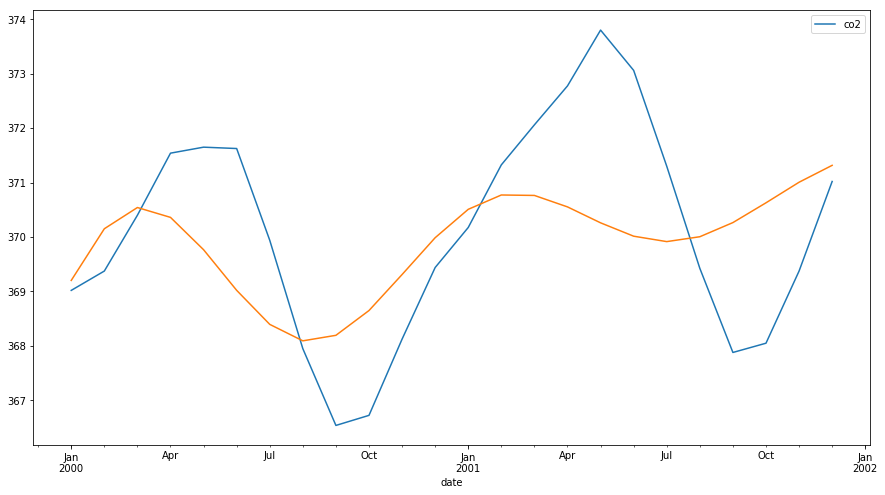

In [214]:
test_ts.plot(figsize=(15, 8))
pred_ts.plot()

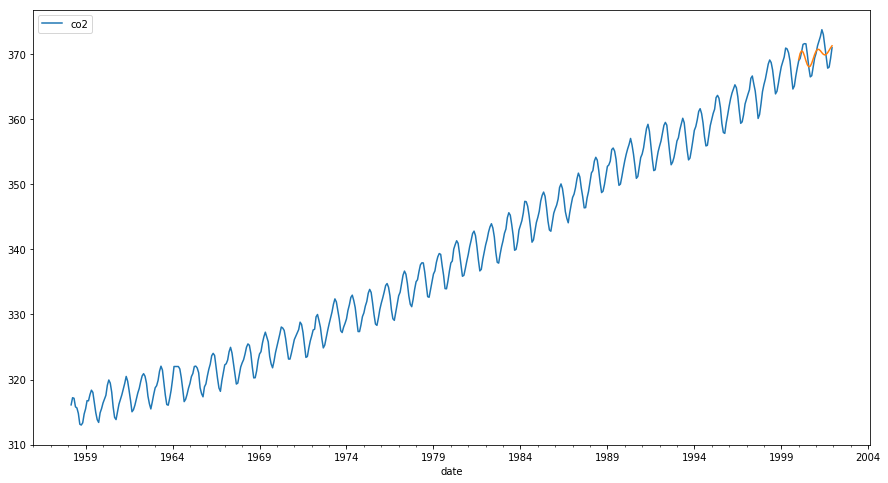

In [215]:
proc_data_df.plot(figsize=(15, 8))
pred_ts.plot()

### 4.2 Teacher Forcing 方法

In [216]:
test_range = pd.date_range(start='2000-01-01', end='2001-12-01', freq='MS')

In [217]:
test_range

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01',
               '2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [219]:
pred_ts = pd.Series(index=test_range)

In [220]:
for cur_month in test_range:
    prev_month = cur_month - pd.Timedelta('1M')
    train_ts = proc_data_df.loc[:prev_month]['co2']
    model = ARIMA(train_ts, order=(2, 1, 2)).fit()
    pred = model.predict(start=cur_month, typ='levels')
    pred_ts.loc[cur_month] = pred.values[0]

In [221]:
pred_ts

2000-01-01    369.202984
2000-02-01    369.860770
2000-03-01    369.457047
2000-04-01    370.762742
2000-05-01    371.775483
2000-06-01    371.042598
2000-07-01    370.934739
2000-08-01    368.373643
2000-09-01    366.657608
2000-10-01    366.171384
2000-11-01    367.722411
2000-12-01    369.844405
2001-01-01    370.751310
2001-02-01    370.756593
2001-03-01    371.923945
2001-04-01    372.153301
2001-05-01    372.684575
2001-06-01    373.766852
2001-07-01    371.812316
2001-08-01    369.659382
2001-09-01    368.233900
2001-10-01    367.447102
2001-11-01    369.077757
2001-12-01    371.095311
Freq: MS, dtype: float64

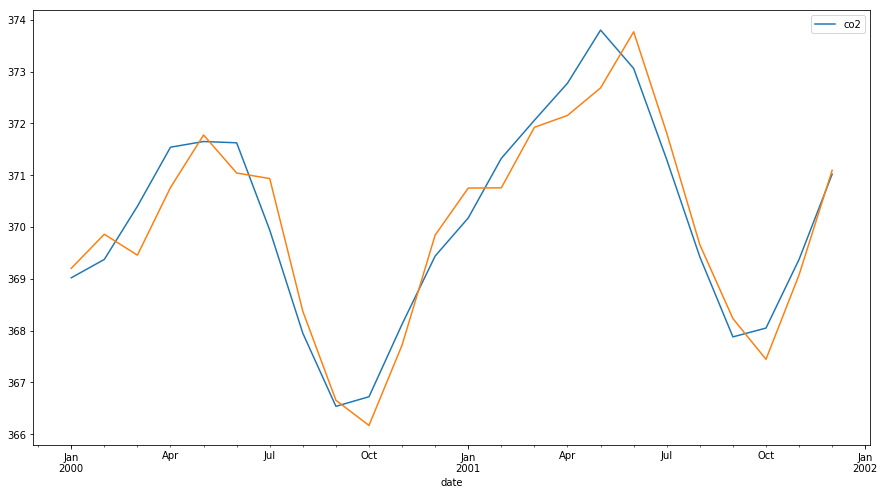

In [222]:
test_ts.plot(figsize=(15, 8))
pred_ts.plot()

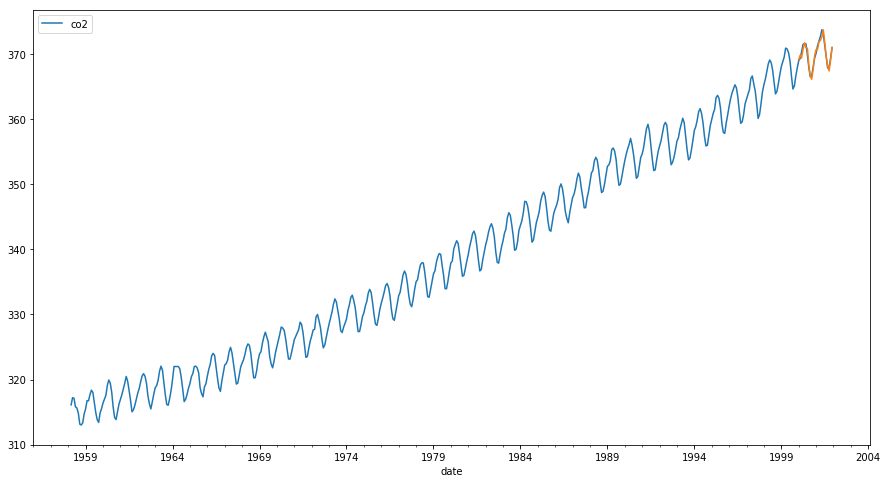

In [223]:
proc_data_df.plot(figsize=(15, 8))
pred_ts.plot()